# IUM etap 1

## Skład zespołu
- Dominika Ferfecka
- Sara Fojt

## Temat projektu
Mamy innowacyjny pomysł - zacznijmy wyprzedzać naszych słuchaczy i tworzyć listę topowych utworów z tydzień przed tym zanim staną się najbardziej popularne! Przegonimy konkurencję i zwiększymy zaangażowanie użytkowników.

## Kontekst
Serwis muzyczny “Pozytywka”, pozwalający użytkownikom na odtwarzanie ulubionych utworów online. Portal pozwala użytkownikom na pomijanie aktualnie odsłuchiwanych utworów oraz na oznaczanie utworów jako polubione.

## Zadanie biznesowe
Tworzenie listy utworów, które w kolejnym tygodniu staną się najbardziej popularne w serwisie. Domyślnie wygenerowana lista będzie zawierać 50 utworów.

## Biznesowe kryterium sukcesu
Piosenki proponowane w stworzonej liście powinny utrzymać się lub stać się jednymi z najpopularniejszych utworów w serwisie w kolejnym tygodniu. Zaproponowana lista powinna zawierać co najmniej 70% takich samych piosenek, co lista rzeczywiście najpopularniejszych piosenek o tej samej liczbie utworów opublikowana w kolejnym tygodniu. Większa popularność utworów oznacza większe zaangażowanie użytkowników co przełoży się na większą ilość odsłuchanych reklam, czyli większy zysk serwisu.

## Zadanie modelowania
Modelowanie szeregów czasowych - przewidywanie popularności piosenek w serwisie w kolejnych tygodniach.

## Dane do modelowania
* dane o artystach, zawierające m.in. gatunki tworzonej przez nich muzyki
* informacje o sesjach użytkowników oraz jakie akcje wykonywali na danych utworach (pomijanie, polubienie itp.)
* informacje o utworach, zawierające liczbowe reprezentacje atrybutów takich jak energiczność, instrumentalność czy popularność (którą będziemy przewidywać)
  
Pełna analiza danych dostępna jest w poniższej sekcji “Analiza danych”.

## Analityczne kryterium sukcesu
Osiągnięcie poziomu rekomendacji:

*Popularne utwory / Zaproponowane utwory > 70%*

We wzorze powyżej "Popularne utwory" oznacza utwory znajdujące się na wygenerowanej przez nas liście utworów, która faktycznie w kolejnym tygodniu stały się popularne. Aby uznać utwór za popularny, musi znajdować się wśród 50 utworów z najwyższymi wartościami w kolumnie *popularity*.

We wzorze powyżej "Popularne utwory" oznacza utwory znajdujące się na wygenerowanej przez nas liście utworów, która faktycznie w kolejnym tygodniu stały się popularne. Aby uznać utwór za popularny, musi znajdować się wśród 50 utworów z najwyższymi wartościami w kolumnie *popularity*.

## Założenia
* atrybut `popularity` w utworach jest zmienny w czasie
* zmiany w popularności utworów są względnie płynnie - nie uwzględniamy czynników takich jak premiery filmów, wydarzenia społeczne, które mają wpływ na popularność niektórych z utworów. Będą to dane typu MNAR (Missing Not At Random), których braku nie jesteśmy w stanie uzupełnić
* atrybuty utworów, takie jak energiczność, instrumentalność itp. które będą jednymi z danych wejściowych modelu, są stałe w czasie
* w większości użytkownicy zachowują się w sposób przewidywalny i nie zmieniają w całości swojego gustu muzycznego z tygodnia na tydzień

## Wstępne propozycje modeli
### Model bazowy
Model bazowy będzie prostym modelem opartym na krótkoterminowym przewidywaniu szeregów czasowych. Wejściem modelu będzie popularność utworu w poprzednich tygodniach, zaś wyjściem będzie przewidywana popularność w tygodniu następnym. Utwory do trenowania modelu będą grupowane według gatunków, jako że ich wykresy popularności mogą znacznie się różnić.

Wstępnie wybranym modelem jest **ARIMA (Autoregressive Integrated Moving Average)** zaimplementowany w bibliotece statsmodels w module tsa.

### Model zaawansowany
Model zaawansowany będzie implementacją neuronowej sieci rekurencyjnej (RNN) w wariancie Long Short-Term Memory (LSTM), który jest specjalnie zaprojektowany do przewidywania szeregów czasowych. Model ten pozwala nam na wprowadzenie większej ilości danych, co skutkuje uchwyceniem bardziej złożonych wzorców. Wejściem modelu, oprócz popularności w czasie, będą również stałe cechy utworów takie jak gatunek, energiczność, wykonawca, instrumentalność itd.

Wstępnie wybraną implementacją będzie model **Sequential LSTM** z biblioteki **tensorflow.keras**. Aby uniknąć nadmiernego dopasowania planowane jest również dodanie warstwy batch-normalizacji oraz dropoutu (dostępne w bibliotece), których hiperparametry będą dostosowane w testach.


# *Analiza danych*

Poniżej zostało przeprowadzana analiza danych jakich otrzymaliśmy.


### Przygotowanie do analizy

In [33]:
!pip install pandas matplotlib

In [2]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
from matplotlib import pyplot as plt
import pandas as pd
import re
import seaborn as sns


In [4]:
SESSIONS = "./V0/sessions.jsonl"
ARTISTS = "./V0/artists.jsonl"
TRACKS = "./V0/tracks.jsonl"

## *Analiza danych o artystach (plik artists)*

In [5]:
artists_data = pd.DataFrame(pd.read_json(ARTISTS, lines=True))
artists_data.head(20)

,id,name,genres
0,7jVv8c5Fj3E9VhNjxT4snq,Lil Nas X,"[country rap, lgbtq+ hip hop, pop rap, queer c..."
1,0xRXCcSX89eobfrshSVdyu,MEDUZA,"[dance pop, edm, pop dance, pop house, tropica..."
2,3OKg7YbOIatODzkRIbLJR4,TheFatRat,[speedrun]
3,4f7KfxeHq9BiylGmyXepGt,Tanishk Bagchi,"[desi pop, filmi, modern bollywood]"
4,56mfhUDKa1vec6rSLZV5Eg,Jawsh 685,[nz pop]
5,523y9KSneKh6APd1hKxLuF,Master KG,[south african house]
6,25UNJbwGZSQKvz5cPLWlv3,Los Dos Carnales,"[corrido, norteno, nuevo regional mexicano, re..."
7,6vTqEFbTtTRJsuIpzZgjxi,Grupo Menos É Mais,"[pagode, pagode novo]"
8,44mEtidu0VdRkIqO4IbkNa,Marca MP,"[corrido, corridos tumbados, nuevo regional me..."
9,6m6e7D2TnV0aYMllFFwMxu,Guilherme & Benuto,[sertanejo pop]


In [6]:
num_rows = artists_data.shape[0]
print(f"W pliku artists jest zawarte {num_rows} wierszy")


W pliku artists jest zawarte 1667 wierszy


### Sprawdzanie wartości null

In [7]:
null_count = artists_data.isnull().sum()
print(null_count)

id         0
name       0
genres    77
dtype: int64


Jest 77 pustych wartości w kolumnie genres

### Analiza kolumny id

In [8]:
artists_data["id"].is_unique

False

In [9]:
# wyświetlenie powtarzających się danych
value_counts = artists_data["id"].value_counts()
value_counts[value_counts > 1]


id
-1    88
Name: count, dtype: int64

Kolumna *id* zawiera 88 wartości *-1*.

### Analiza kolumny name

In [10]:
# weryfikacja znaków specjalnych

special_chars_pattern = r"[^a-zA-Z0-9\s]"

def extract_special_characters(name):
    return re.findall(special_chars_pattern, name)

artists_data["special_char_count"] = artists_data["name"].apply(lambda x: len(extract_special_characters(x)))
artists_data["special_characters"] = artists_data["name"].apply(extract_special_characters)

names_with_special_chars = artists_data[artists_data["special_char_count"] > 0]

print(names_with_special_chars[["name", "special_char_count", "special_characters"]])

artists_data = pd.DataFrame(pd.read_json(ARTISTS, lines=True))


                    name  special_char_count special_characters
7     Grupo Menos É Mais                   1                [É]
9     Guilherme & Benuto                   1                [&]
18     Die drei ??? Kids                   3          [?, ?, ?]
28                    優里                   2             [優, 里]
42            badmómzjay                   1                [ó]
...                  ...                 ...                ...
1592             Ben&Ben                   1                [&]
1602               Beéle                   1                [é]
1604         Joey Bada$$                   2             [$, $]
1607                Snøw                   1                [ø]
1648               Aminé                   1                [é]

[201 rows x 3 columns]


Jest 201 nazw, które zawierają znaki specjalne.

### Analiza kolumny genres

In [11]:
# zliczenie rodzajów gatunków

unique_genres_count = artists_data['genres'].explode().nunique()
print(f"Liczba unikalnych gatunków: {unique_genres_count}")

sample_genres = artists_data['genres'].explode().head(50)
print("\nPrzykłady gatunków:")
print(sample_genres.tolist())


Liczba unikalnych gatunków: 828

Przykłady gatunków:
['country rap', 'lgbtq+ hip hop', 'pop rap', 'queer country', 'dance pop', 'edm', 'pop dance', 'pop house', 'tropical house', 'speedrun', 'desi pop', 'filmi', 'modern bollywood', 'nz pop', 'south african house', 'corrido', 'norteno', 'nuevo regional mexicano', 'regional mexican', 'pagode', 'pagode novo', 'corrido', 'corridos tumbados', 'nuevo regional mexicano', 'regional mexican', 'sierreno', 'sertanejo pop', 'latin', 'reggaeton', 'reggaeton flow', 'trap latino', 'dutch hip hop', 'dutch rap pop', 'canadian hip hop', 'pop', 'afro dancehall', 'afropop', 'ghanaian hip hop', 'nigerian pop', 'swedish dancehall', 'albanian hip hop', 'german hip hop', 'lo-fi cover', 'pagode', 'latin', 'latin pop', 'reggaeton', 'reggaeton flow', 'trap latino', 'tropical']


## *Analiza danych o utworach (plik tracks)*

In [12]:
tracks_data = pd.DataFrame(pd.read_json(TRACKS, lines=True))
tracks_data.head(20)


,id,name,popularity,duration_ms,explicit,id_artist,release_date,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0RNxWy0PC3AyH4ThH3aGK6,Mack the Knife,55.0,201467,0,19eLuQmk9aCobbVDHc6eek,1929,0.673,0.3770,0,-14.141,0.0697,0.586,0.000000,0.3320,0.7130,88.973
1,2W889aLIKxULEefrleFBFI,Someone to Watch Over Me,54.0,198000,0,1Mxqyy3pSjf8kZZL4QVxS0,1943,0.204,0.1510,2,-17.842,0.0418,0.947,0.000009,0.3210,0.1340,91.783
2,4Pnzw1nLOpDNV6MKI5ueIR,Nancy (With the Laughing Face) - 78rpm Version,55.0,199000,0,1Mxqyy3pSjf8kZZL4QVxS0,1944,0.295,0.0826,1,-19.569,0.0367,0.984,0.000358,0.1560,0.1690,128.600
3,7GLmfKOe5BfOXk7334DoKt,Saturday Night (Is The Loneliest Night In The ...,54.0,163000,0,1Mxqyy3pSjf8kZZL4QVxS0,1944,0.561,0.3350,9,-11.093,0.0499,0.840,0.000002,0.7880,0.5900,126.974
4,6kD1SNGPkfX9LwaGd1FG92,Put Your Dreams Away (For Another Day),53.0,186173,0,1Mxqyy3pSjf8kZZL4QVxS0,1944,0.197,0.0546,1,-22.411,0.0346,0.950,0.276000,0.1520,0.1000,90.150
5,5RcvlmVx2xtFcp2Ta5pw7X,Someone To Watch Over Me,57.0,196667,0,5V0MlUE1Bft0mbLlND7FJz,1950-09-11,0.354,0.0851,7,-13.738,0.0345,0.990,0.000004,0.1230,0.1970,97.684
6,None,I've Got A Crush On You,56.0,196440,0,5V0MlUE1Bft0mbLlND7FJz,1950-09-11,0.455,0.1060,2,-14.086,0.0422,0.986,0.000000,0.1220,0.2580,66.807
7,0x0ffSAP6PkdoDgHOfroof,My Funny Valentine - Remastered,54.0,150667,0,1Mxqyy3pSjf8kZZL4QVxS0,1954-01-01,0.257,0.1250,11,-14.267,0.0332,0.891,0.000000,0.1080,0.2450,84.930
8,0Hsc0sIaxOxXBZbT3ms2oj,In The Wee Small Hours Of The Morning - Remast...,60.0,180933,0,1Mxqyy3pSjf8kZZL4QVxS0,1955,0.290,0.0874,0,-16.119,0.0346,0.856,0.000957,0.1090,0.0734,114.997
9,3aEJMh1cXKEjgh52claxQp,I've Got You Under My Skin - Remastered 1998,68.0,223760,0,1Mxqyy3pSjf8kZZL4QVxS0,1956-03,0.585,0.2470,1,-12.612,0.0400,0.452,0.000009,0.1070,0.5910,127.150


In [13]:
num_rows = tracks_data.shape[0]
print(f"W pliku tracks jest zawarte {num_rows} wierszy")


W pliku tracks jest zawarte 22412 wierszy


### Sprawdzanie wartości null

In [14]:
null_count = tracks_data.isnull().sum()
print(null_count)

id                  1173
name                1102
popularity          1113
duration_ms            0
explicit               0
id_artist           1143
release_date           0
danceability           0
energy                 0
key                    0
loudness               0
speechiness            0
acousticness           0
instrumentalness       0
liveness               0
valence                0
tempo                  0
dtype: int64


Występuje dużo wartości pustych w kolumnach *id*, *name*, *popularity*, *id_artists*

### Analiza kolumny name

In [15]:
# weryfikacja znaków specjalnych

special_chars_pattern = r"[^a-zA-Z0-9\s]"

def extract_special_characters(name):
    if isinstance(name, str):
        return re.findall(special_chars_pattern, name)
    else:
        return [] 

tracks_data["special_char_count"] = tracks_data["name"].apply(lambda x: len(extract_special_characters(x)))
tracks_data["special_characters"] = tracks_data["name"].apply(extract_special_characters)

names_with_special_chars = tracks_data[tracks_data["special_char_count"] > 0]

print(names_with_special_chars[["name", "special_char_count", "special_characters"]])

tracks_data = pd.DataFrame(pd.read_json(TRACKS, lines=True))


                                                    name  special_char_count  \
2         Nancy (With the Laughing Face) - 78rpm Version                   3   
3      Saturday Night (Is The Loneliest Night In The ...                   2   
4                 Put Your Dreams Away (For Another Day)                   2   
6                                I've Got A Crush On You                   1   
7                        My Funny Valentine - Remastered                   1   
...                                                  ...                 ...   
22378                             Två sekunder på loftet                   2   
22381                              Look What You've Done                   1   
22382                                Sätter Dom På Plats                   2   
22392                      Immortals - From "Big Hero 6”                   3   
22411                          What They'll Say About Us                   1   

      special_characters  
2           

## Analiza kolumny id_artist
Sprawdzenie czy rekordy artystów z danym id istnieją w zbiorze danych

In [47]:
not_null_tracks_data = tracks_data[tracks_data['id_artist'].notnull()]
not_null_artists_data = artists_data[artists_data['id'].notnull()]

missing_ids_tracks_num = not_null_tracks_data[~not_null_tracks_data['id_artist'].isin(not_null_artists_data['id'])]
missing_ids_artists_num = not_null_tracks_data[~not_null_tracks_data['id_artist'].isin(not_null_artists_data['id'])]['id_artist'].unique()

missing_count_tracks_num = missing_ids_tracks_num.shape[0]
missing_count_artists_num = missing_ids_artists_num.shape[0]

print(f"Liczba utworów, których autorów nie ma w zbiorze: {missing_count_tracks_num}")
print(f"Liczba brakujących artystów, których utwory znajdują się w zbiorze: {missing_count_artists_num}")

Liczba utworów, których autorów nie ma w zbiorze: 1161
Liczba brakujących artystów, których utwory znajdują się w zbiorze: 76


### Liczba wielokrotnego wystąpienia danego utworu
Plik tracks.json zawiera wielokrotne wystąpienia danego utworu ze zmienionym atrybutem *popularity*.

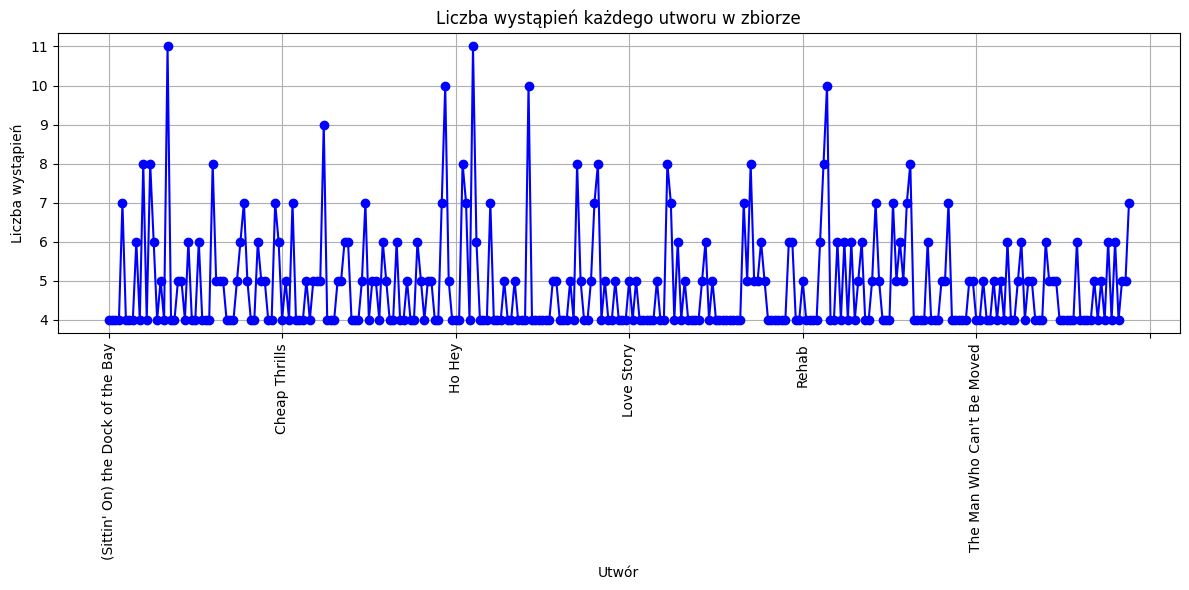

Liczba powtórzonych utworów z różnym popularity: 295
Liczba powtórzeń | Liczba utworów
4     164
5      68
6      31
7      16
8      10
10      3
11      2
9       1
Name: count, dtype: int64


In [48]:
tracks_counts = tracks_data.groupby(tracks_data["name"]).size()
filtered_tracks_counts = tracks_counts[tracks_counts > 3]
plt.figure(figsize=(12, 6))
filtered_tracks_counts.plot(kind="line", marker='o', color='b')
plt.title("Liczba wystąpień każdego utworu w zbiorze")
plt.xlabel("Utwór")
plt.ylabel("Liczba wystąpień")
plt.xticks(rotation=90) 
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Liczba powtórzonych utworów z różnym popularity: {len(filtered_tracks_counts)}")
print(f"Liczba powtórzeń | Liczba utworów")
print(filtered_tracks_counts.value_counts())

### Rozkład kluczowych atrybutów

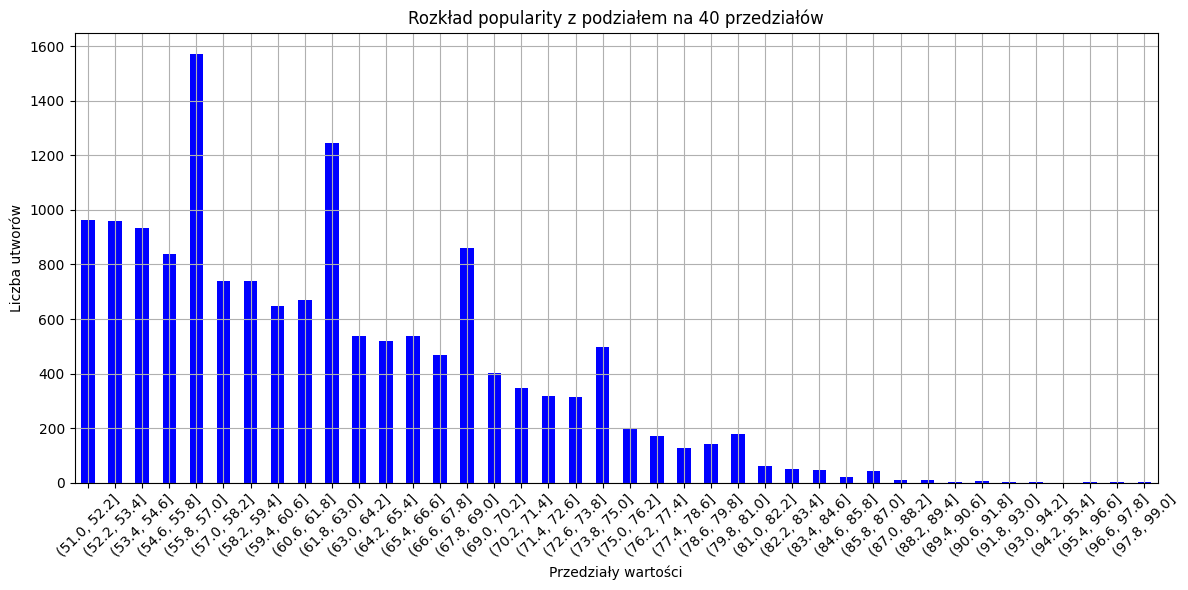

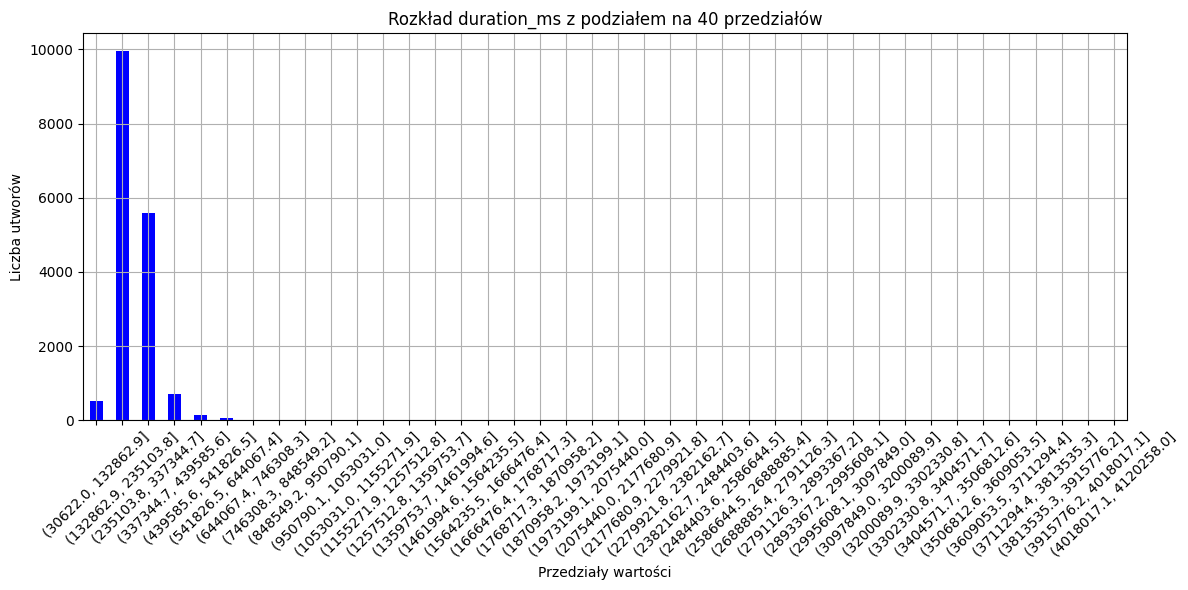

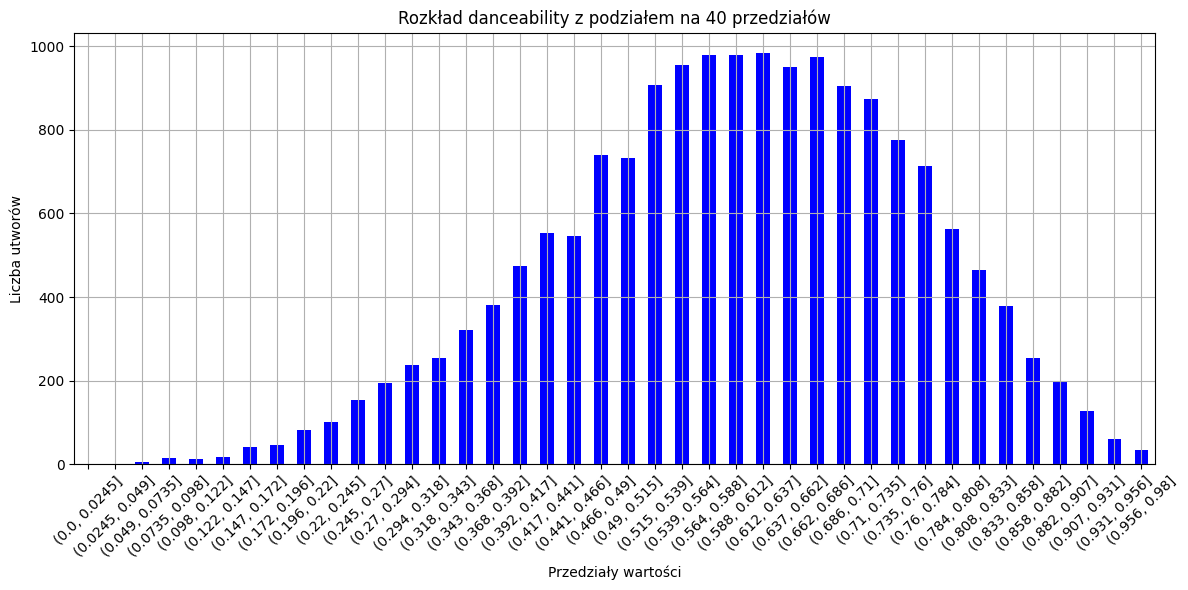

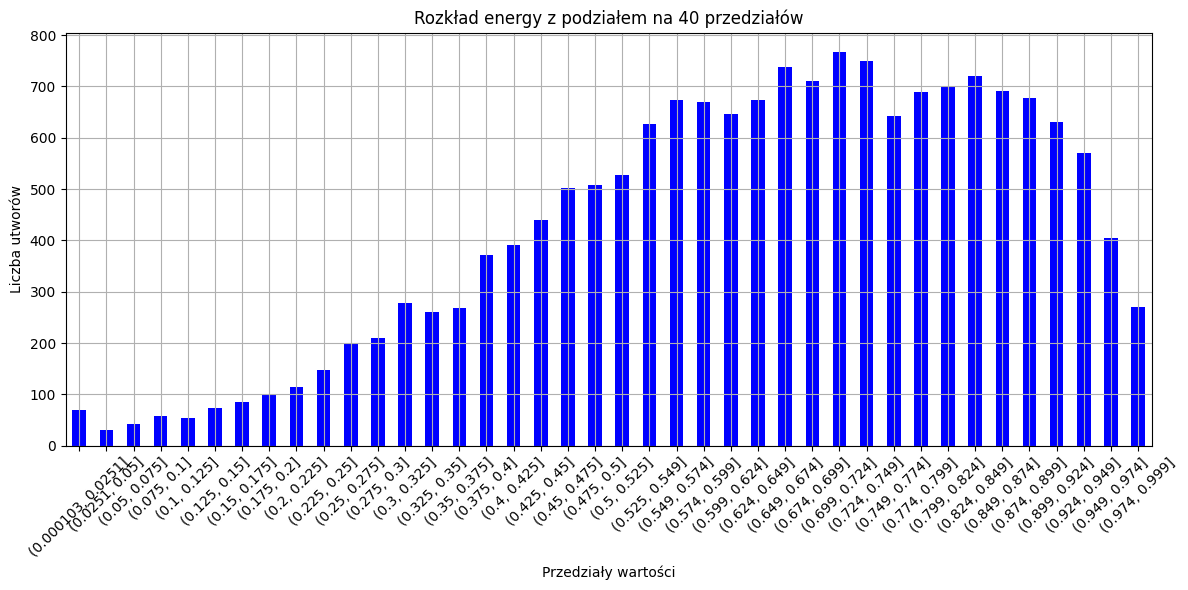

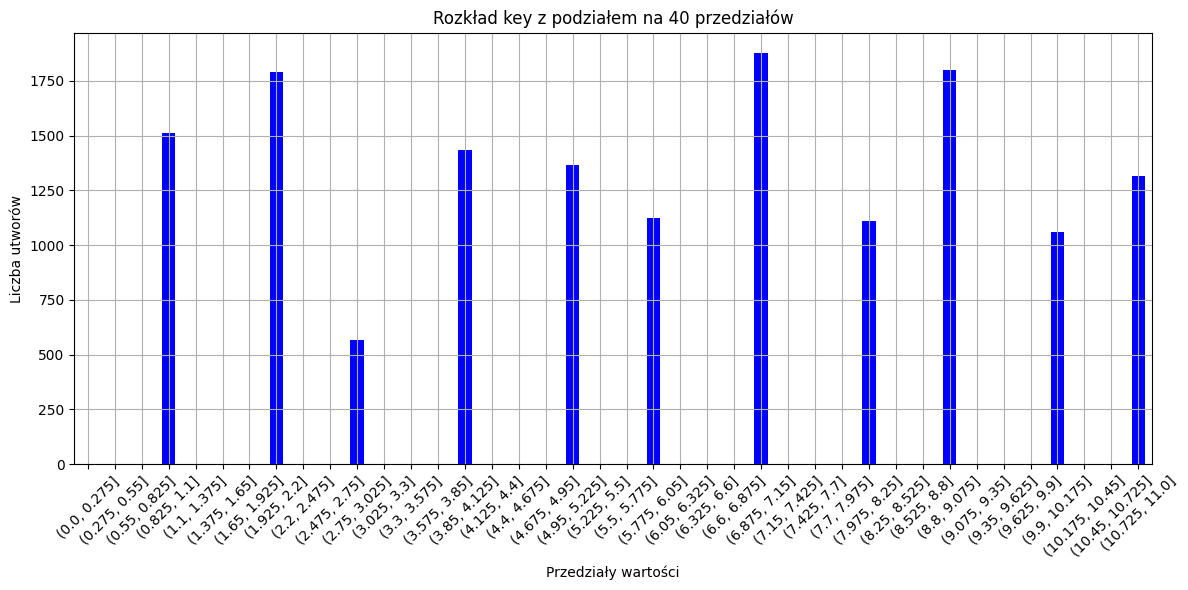

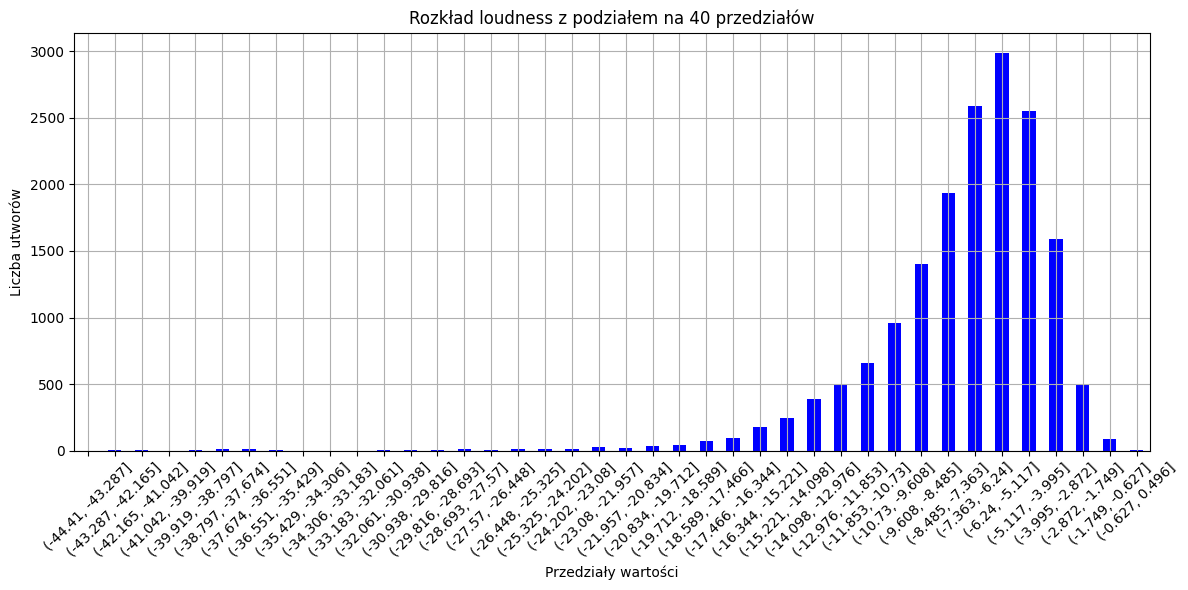

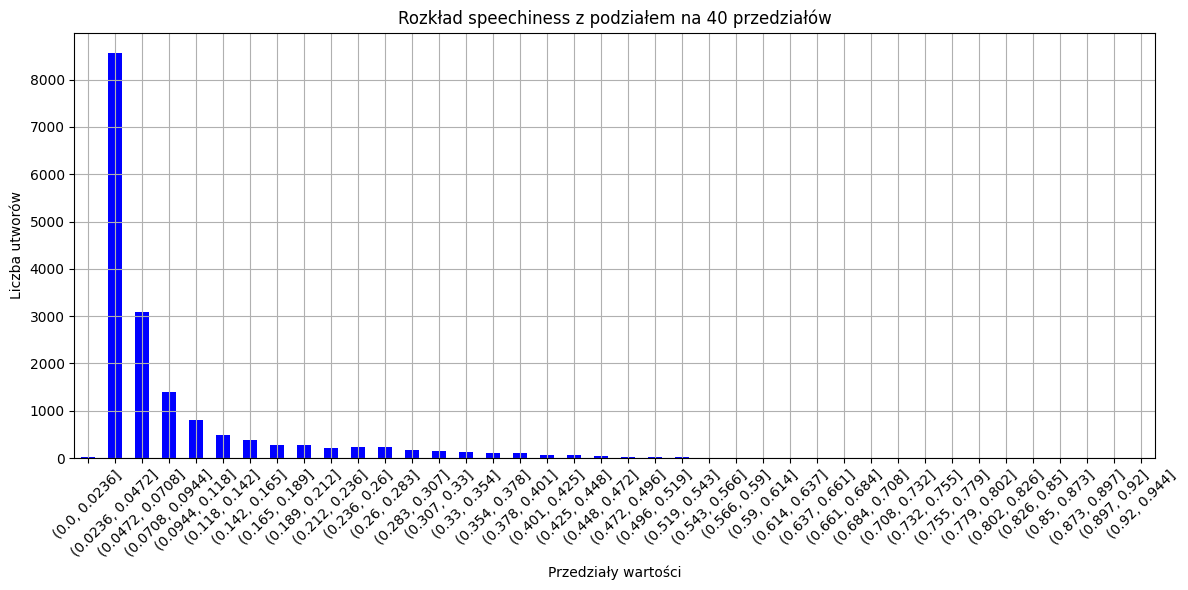

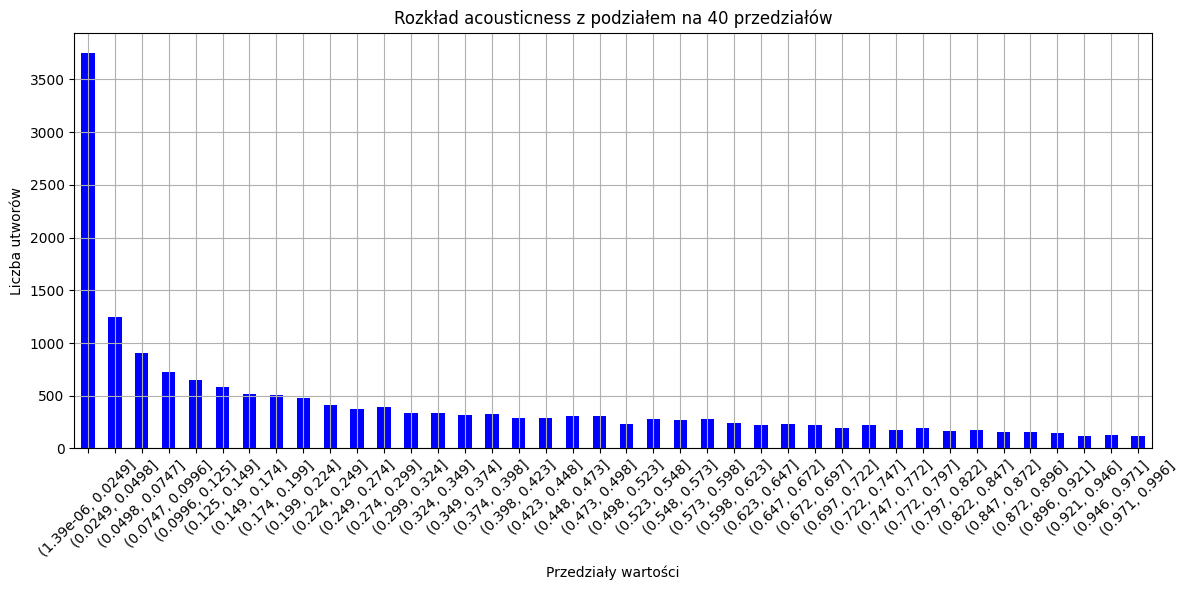

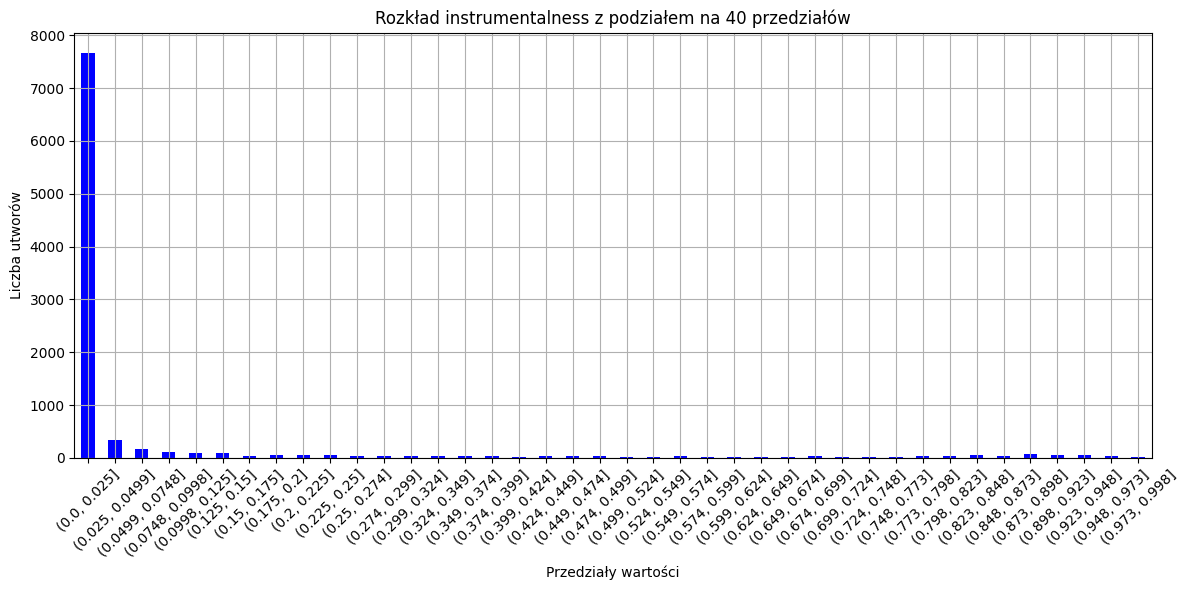

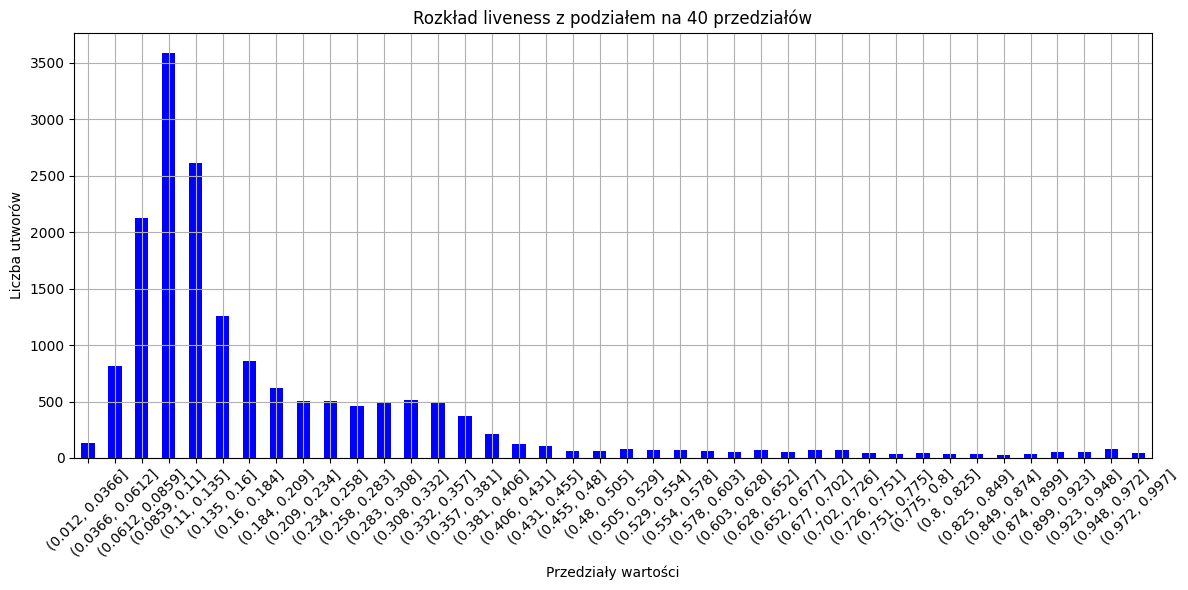

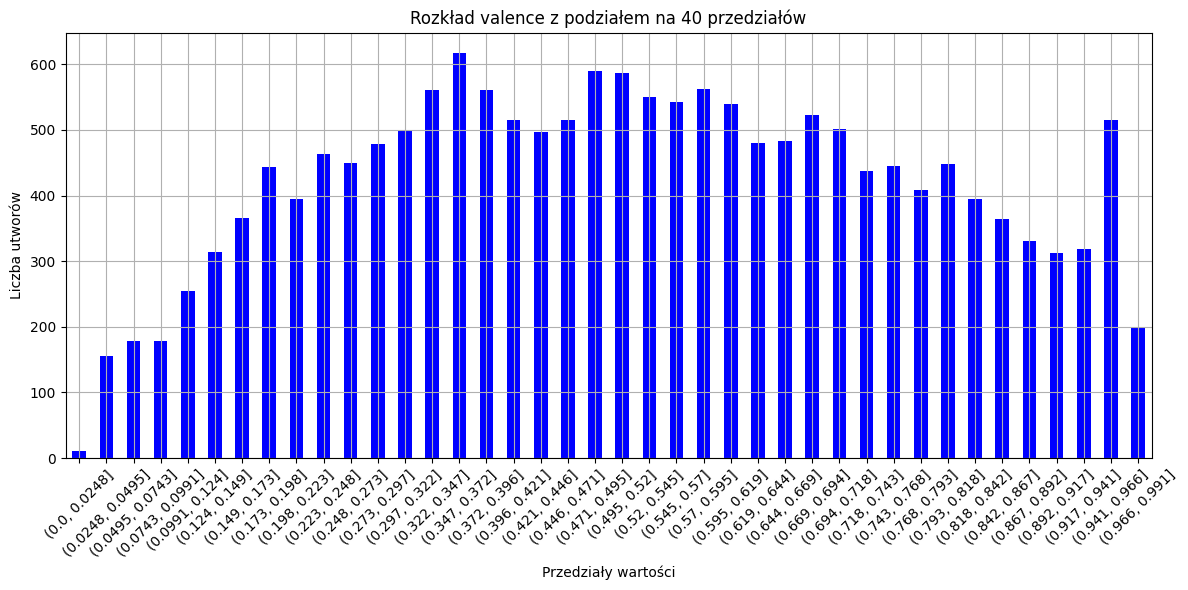

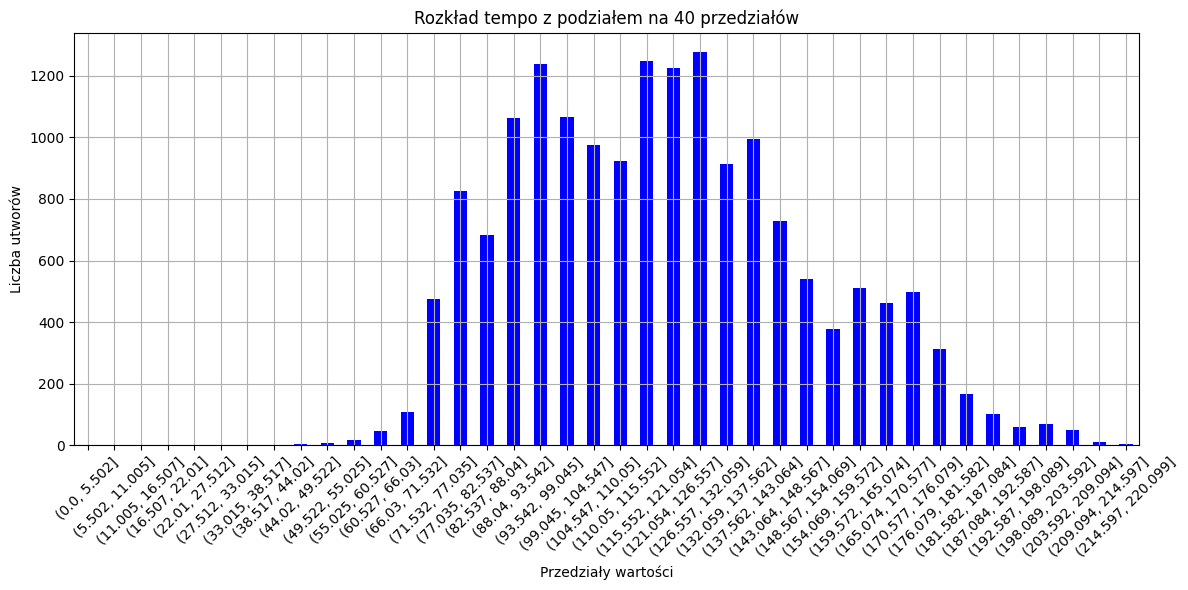

In [49]:
unique_tracks_data = tracks_data.drop_duplicates(subset="name")
unique_tracks_data = unique_tracks_data.copy()
params = ["popularity", "duration_ms", "danceability", "energy", "key", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo"]


for param in params:
    bins = np.linspace(unique_tracks_data[param].min(), unique_tracks_data[param].max(), 41)

    unique_tracks_data['bin'] = pd.cut(unique_tracks_data[param], bins)
    bin_counts = unique_tracks_data['bin'].value_counts().sort_index()

    plt.figure(figsize=(12, 6))
    bin_counts.plot(kind='bar', color='blue')

    plt.title(f'Rozkład {param} z podziałem na 40 przedziałów')
    plt.xlabel('Przedziały wartości')
    plt.ylabel('Liczba utworów')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

## *Analiza danych o sesjach użytkowników (plik sessions)*

In [50]:
sessions_data = pd.DataFrame(pd.read_json(SESSIONS, lines=True))
sessions_data.head(20)

,session_id,timestamp,user_id,track_id,event_type
0,124,2023-10-25 10:13:55.258944,601.0,1Duym1lVQurgKHHSqpOWhY,play
1,124,2023-10-25 10:15:29.065944,601.0,None,skip
2,124,2023-10-25 10:15:34.065944,601.0,None,advertisment
3,124,2023-10-25 10:15:34.065944,601.0,6XFduBZIOMyOV8sCcHuYzb,play
4,124,2023-10-25 10:16:21.994944,601.0,6XFduBZIOMyOV8sCcHuYzb,like
5,124,2023-10-25 10:17:49.679944,601.0,None,skip
6,124,2023-10-25 10:17:54.679944,601.0,2fXLhLA7cPYEmQ1NbeAtBD,play
7,124,2023-10-25 10:20:52.121944,601.0,2fXLhLA7cPYEmQ1NbeAtBD,skip
8,124,2023-10-25 10:20:57.121944,601.0,4p8QcNkaq2FQj8uGJ7HEDK,play
9,124,2023-10-25 10:25:17.388944,601.0,None,play


In [51]:
num_rows = sessions_data.shape[0]
print(f"W pliku sessions jest zawarte {num_rows} wierszy")


W pliku sessions jest zawarte 26764 wierszy


### Sprawdzanie wartości null

In [52]:
null_count = sessions_data.isnull().sum()
print(null_count)

session_id       0
timestamp        0
user_id       1321
track_id      4910
event_type    1316
dtype: int64


W kolumnach takich jak *track_id*, *event_type*, *user_id* występują wartości null

### Zliczenie użytkowników

In [53]:
unique_users_count = sessions_data["user_id"].nunique()
print(f"Ilość użytkowników: {unique_users_count}")

Ilość użytkowników: 50


### Częstotliwość danych

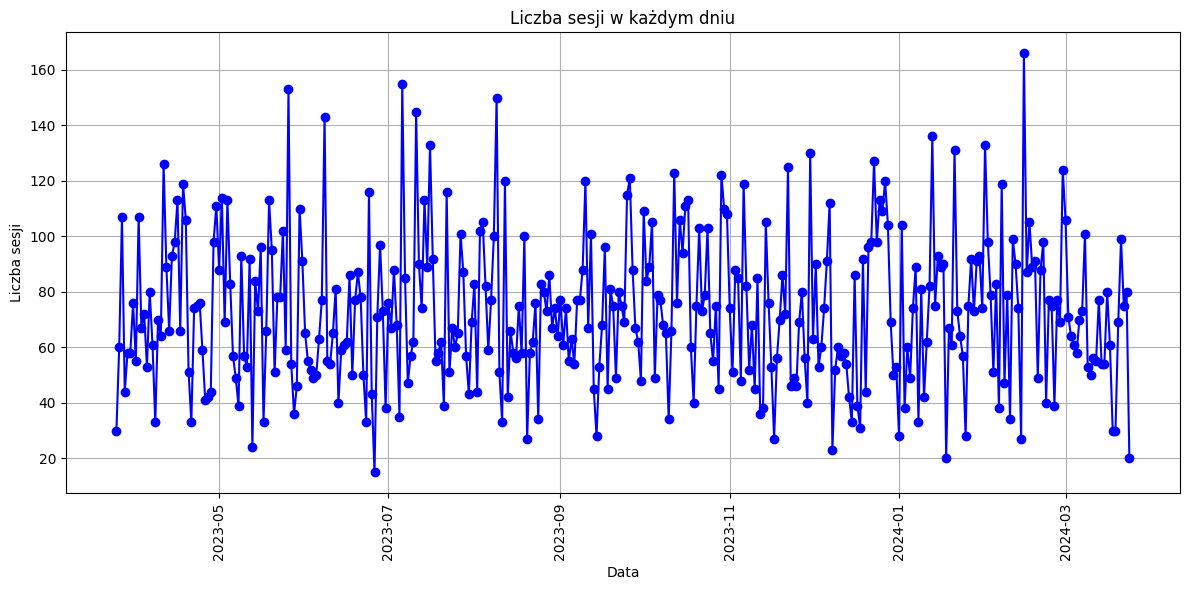

In [54]:
sessions_data["timestamp"] = pd.to_datetime(sessions_data["timestamp"])
sessions_per_day = sessions_data.groupby(sessions_data["timestamp"].dt.date).size()

plt.figure(figsize=(12, 6))
sessions_per_day.plot(kind="line", marker='o', color='b')

plt.title("Liczba sesji w każdym dniu")
plt.xlabel("Data")
plt.ylabel("Liczba sesji")
plt.xticks(rotation=90) 
plt.grid(True)

plt.tight_layout()
plt.show()

### Rozkład sesji dla użytkowników

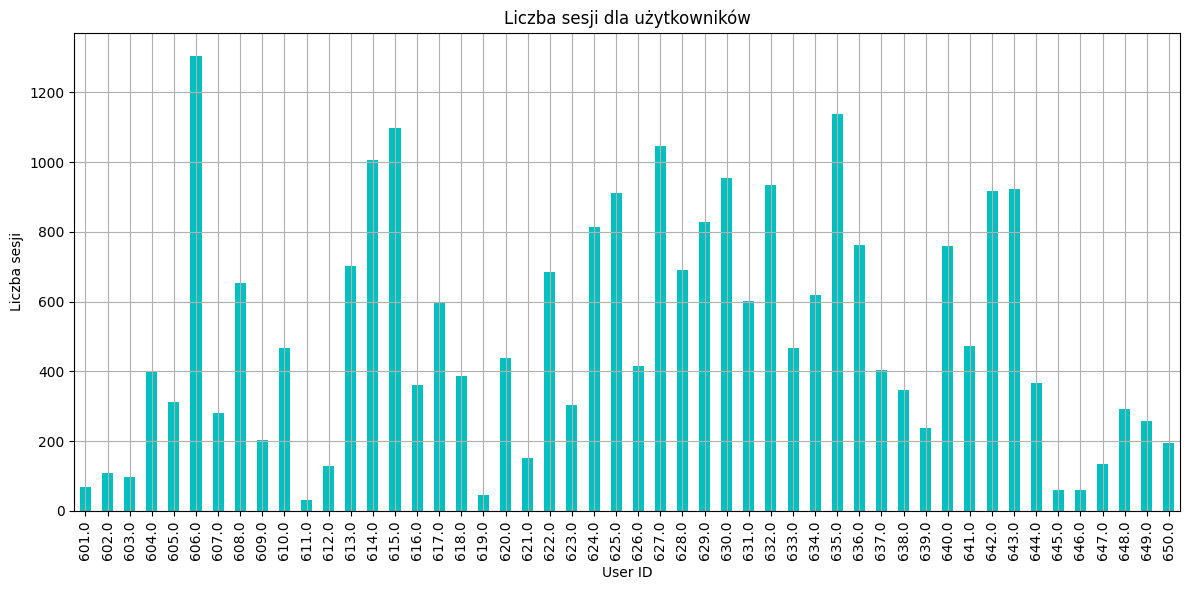

In [55]:
sessions_per_user = sessions_data.groupby("user_id").size()

plt.figure(figsize=(12, 6))
sessions_per_user.plot(kind="bar", color='c')

plt.title("Liczba sesji dla użytkowników")
plt.xlabel("User ID")
plt.ylabel("Liczba sesji")
plt.xticks(rotation=90) 
plt.grid(True)

plt.tight_layout()
plt.show()


### Analiza kolumny track_id
Sprawdzenie powiązania dostępnych danych na podstawie kolumny track_id

In [56]:
not_null_tracks_data = tracks_data[tracks_data['id'].notnull()]
not_null_sessions_data = sessions_data[sessions_data['track_id'].notnull()]

missing_ids_sessions_num = not_null_sessions_data[~not_null_sessions_data['track_id'].isin(not_null_tracks_data['id'])]['track_id']
missing_ids_tracks_num = not_null_sessions_data[~not_null_sessions_data['track_id'].isin(not_null_tracks_data['id'])]['track_id'].unique()

missing_count_sessions_num = missing_ids_sessions_num.shape[0]
missing_count_tracks_num = missing_ids_tracks_num.shape[0]

print(f"Liczba odtworzeń, których utworów nie ma w zbiorze: {missing_count_sessions_num}")
print(f"Liczba brakujących utworów, których odtworzenia znajdują się w zbiorze: {missing_count_artists_num}")

Liczba odtworzeń, których utworów nie ma w zbiorze: 1149
Liczba brakujących utworów, których odtworzenia znajdują się w zbiorze: 76


Lets go again

Potrzebne zbiory i atrybuty

## Potrzebne zbiory danych i atrybuty
- Dane utworów (tracks):
    - id - identyfikacja utworów
    - name - nazwa utworu będzie wykorzystywana do czytelnego tworzenia playlist
    - popularity - aktualna i historyczna popularność będzie wykorzystywana jako wartość bazowa do obliczenia przewidywanej popularity
    - id_artist - identyfikacja kto jest autorem utworu
    - release_date - data publikacji może wpływać na popularność, data zostanie ograniczona tylko do roku publikacji
    - duration_ms - czas utworu może wpływać na popularność
    - explicit, danceability, energy, key, loudness, speechiness, acousticness, instrumentalness, liveness, valence, tempo - cechy utworów, które mogą wpływać na popularność:
- Dane artystów (artists):
    - name - nazwisko artysty będzie wykorzystywane do czytelnego tworzenia playlist
    - genres - gatunki w których tworzą artyści może wpływać na popularność utworu
- Dane sesji (sessions):
    - event_type - liczba play/like/skip będzie wpływać na popularność
    - timestamp - wykorzystywana do sprecyzowania kiedy następowały dane akcje związane z utworem

- Dane użytkowników (brakujące) - do sprawdzenia reprezentytawności danych


## Zmienne wejściowe
- Dane utworów (tracks):
    - id
    - popularity
    - duration_ms
    - explicit
    - year_of_release
    - danceability
    - energy
    - key
    - loudness
    - speechiness
    - acousticness
    - instrumentalness
    - liveness
    - valence
    - tempo
- Dane artystów (artists):
    - genres
- Dane sesji (sessions):
    - play_count
    - like_count
    - skip_count
    - timestamp 


## Zmienne wyjściowe
- popularity - przewidywana popularność na przyszły tydzień, na podstawie jej będą tworzone utwory z najbardziej popularnymi w przyszłym tygodniu utworami

## Korelacja popularności z cechami utworów

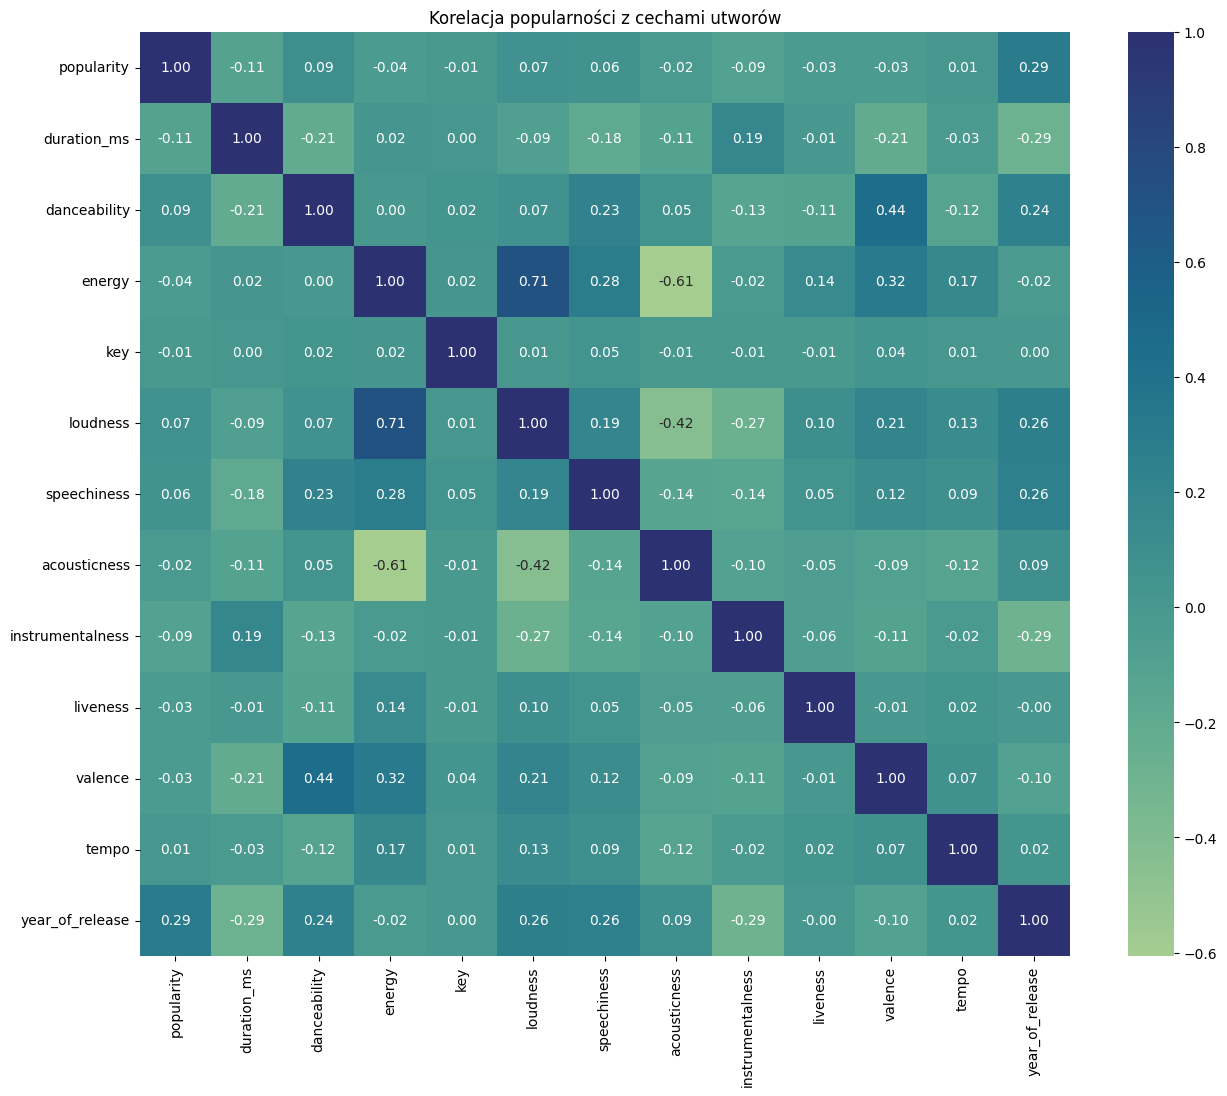

In [24]:
tracks_data_for_popularity = tracks_data.dropna()

tracks_data_for_popularity_new = tracks_data_for_popularity.drop(columns=["name", "id", "id_artist", "release_date", "explicit"])
tracks_data_for_popularity_new["year_of_release"] = tracks_data_for_popularity["release_date"].str[:4].astype(int)
moved = ["popularity"]
rest_columns = [col for col in tracks_data_for_popularity_new.columns if col not in moved]
tracks_data_for_popularity_new = tracks_data_for_popularity_new[moved + rest_columns]

spearman_corr_matrix = tracks_data_for_popularity_new.corr(method="spearman")

plt.figure(figsize=(15, 12))
sns.heatmap(spearman_corr_matrix, annot=True, cmap="crest", fmt=".2f")
plt.title("Korelacja popularności z cechami utworów")
plt.show()


## Korelacja popularności utworów z sesjami użytkowników

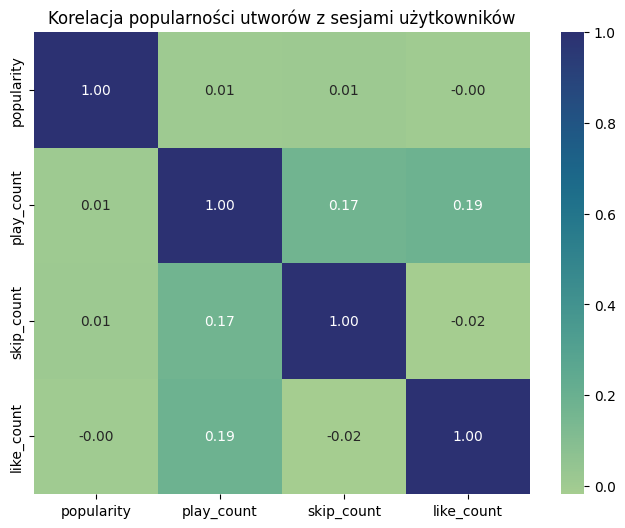

In [25]:
sessions_data = sessions_data[
    sessions_data["event_type"].notnull() & (sessions_data["event_type"] != "advertisment")
]

session_events = (
    sessions_data.groupby(["track_id", "event_type"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

session_events.columns = ["track_id", "like_count", "play_count", "skip_count"]
merged_data = pd.merge(tracks_data, session_events, left_on="id", right_on="track_id", how="inner")
correlation_data = merged_data[["popularity", "play_count", "skip_count", "like_count"]]

correlation_data = correlation_data.dropna()
popularity_corr = correlation_data.corr(method="spearman")


plt.figure(figsize=(8, 6))
sns.heatmap(popularity_corr, annot=True, cmap="crest", fmt=".2f")
plt.title("Korelacja popularności utworów z sesjami użytkowników")
plt.show()

# Podsumowanie i prósba o poprawienie danych

### Dane o artystach (plik `artists`):
1. **Puste wartości** w kolumnie `genres`.
2. **Nieprawidłowe wartości** `-1` w polu `id` - wygląda jak błąd w zbieraniu danych.
3. Część danych w polu `name` zawiera **znaki specjalne** - prośba o weryfikację, czy dane zostały odpowiednio pobrane.
4. W polu `genres` znajdują się wartości z bardzo szerokiej listy gatunków muzycznych. Sugerujemy ich **ograniczenie**, np. zamiast wielu podkategorii rocka, wprowadzenie jednego ogólnego rodzaju (np. "rock"), co ułatwi analizę.
5. **Brakujący artyści**, których utwory są obecne w zbiorze. ID **76** artystów jest obecne w informacjach **1161** utworów, lecz nie mają one odpowiadających rekordów w pliku artists.json. Prosimy o dosłanie rekordów brakujących artystów.

### Dane o utworach (plik `tracks`):
1. W kolumnach takich jak `id`, `name`, `popularity`, `id_artist` występują **wartości null**. Prośba o uzupełnienie wartości.
2. Część danych w polu `name` zawiera **znaki specjalne** - prośba o weryfikację, czy dane zostały odpowiednio pobrane.
3. Wartości w kolumnie `release_date` są **niejednolite** – niektóre zawierają pełną datę, inne tylko rok lub miesiąc. Sugerujemy **ujednolicenie formatu** do pełnej daty (YYYY-MM-DD) i uzupełnienie brakujących wartości tam, gdzie to możliwe.
4. Prośba o **informację** w jakiej skali i w jaki sposób jest mierzone pole `popularity`. Dodatkowo, czy istnieje opcja uzyskania danych o **zmianach popularności w czasie** (np. tygodniowych różnic), co ułatwi wyznaczanie przyszłych trendów.
5. Prośba o **wyjaśnienie znaczenia pola** `explicit`.
6. Prośba o **informację** w jakich jednostkach i skalach mierzone są poniższe pola:
   - `danceability`
   - `energy`
   - `key`
   - `loudness`
   - `speechiness`
   - `acousticness`
   - `instrumentalness`
   - `liveness`
   - `valence`
   - `tempo`
7. Jeśli to możliwe, prosimy o **uzupełnienie danych o gatunku muzycznym** dla każdego utworu. Ta informacja będzie pomocna w przewidywaniu popularności utworów.
8. **Brakujące utwory**, których odtworzenia są obecne w zbiorze. **76** utworów jest obecne w informacjach **1149** odtworzeń, lecz nie mają one odpowiadających rekordów w pliku tracks.json. Prosimy o dosłanie rekordów brakujących utworów.

### Dane o sesjach użytkowników (plik `sessions`):
1. W kolumnach takich jak `track_id`, `event_type`, `user_id` występują **wartości null**. Prośba o uzupełnienie wartości.
2. **Dane obejmują tylko 50 użytkowników** - prosimy o zwiększenie liczby użytkowników danych, by móc zrobić bardziej reprezentatywną analizę.
3. Prośba o **udostępnienie danych z większą częstotliwością**, by było widoczne, co się dzieje w każdym poszczególnym dniu, dla wielu użytkowników.

### Dane o użytkownikach:
1. Prośba o podanie **bazy użytkowników**. Na ten moment mamy tylko identyfikatory użytkowników w ich sesjach, ale nie mamy żadnych informacji o nich. Przykładowe przydatne informacje, które pomogą nam stwierdzić reprezentatywność populacji:
   - region, obszar geograficzny, w którym użytkownik się znajduje
   - wiek
   - płeć
   - ulubione gatunki muzyczne i artyści
   - zapisane playlisty
